In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="MCes8WcoxrEM2BH9DY00")
project = rf.workspace("posturecorrection").project("posture_correction_v4")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to posture_correction_v4-2 in folder:: 100%|███████| 4680/4680 [00:08<00:00, 558.16it/s]


In [6]:
!pip install ultralytics --q

In [7]:
from ultralytics import YOLO

In [8]:
yolo_model = YOLO('yolo11n-pose.pt')

In [9]:
import os
import pandas as pd

In [14]:
# Path to dataset
dataset_path = (r"C:\Users\hp\posture_correction_v4-2")

# List of splits
splits = ["train", "valid", "test"]

# Initialize storage
data_rows = []

for split in splits:
    split_path = os.path.join(dataset_path, split)

    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)

        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            # Run YOLO pose estimation
            results = yolo_model(img_path, verbose=False)

            for r in results:
                if r.keypoints is None:  # skip if no person detected
                    continue

                # Get keypoints (x,y) for first person detected
                kps = r.keypoints.xy.cpu().numpy()[0]  # shape (num_keypoints, 2)
                flat_kps = kps.flatten().tolist()     # [x1, y1, x2, y2, ..., xn, yn]

                # Add label
                row = flat_kps + [class_name, split]
                data_rows.append(row)


In [17]:
# Build DataFrame
num_keypoints = len(kps)  # detected keypoints count
columns = []
for i in range(num_keypoints):
    columns += [f"x{i+1}", f"y{i+1}"]

columns += ["label", "split"]

df = pd.DataFrame(data_rows, columns=columns)

# Save to CSV
csv_path = r"C:\Users\hp\posture_correction_v4-2/posture_keypoints.csv"
df.to_csv(csv_path, index=False)

print(f"CSV saved at {csv_path}")

CSV saved at C:\Users\hp\posture_correction_v4-2/posture_keypoints.csv


In [18]:
df = df.drop(columns = ['x8', 'y8', 'x9', 'y9', 'x10', 'y10', 'x11', 'y11', 'x12', 'y12',
                        'x13', 'y13', 'x14', 'y14', 'x15', 'y15', 'x16', 'y16', 'x17', 'y17'])

In [19]:
df["label"] = df["label"].replace("looks good", "0")
df["label"] = df["label"].replace("sit up straight", "1")
df["label"] = df["label"].replace("straighten head", "1")  # 0 for healthy, 1 for not healthy

In [20]:
print(df["label"].unique())
print(df.head())
print(df.shape)

['0' '1']
           x1          y1          x2          y2          x3          y3  \
0  856.095337  552.021667  929.811035  476.478027  786.058350  476.577911   
1  557.995667  329.540985  602.860962  286.831207  510.972931  285.646149   
2  890.151245  688.774353  978.858582  597.446655  813.961609  598.194336   
3  557.726440  328.089935  603.012878  288.047485  511.268311  285.858765   
4  851.219238  550.403015  925.740051  477.397247  782.697205  477.721802   

            x4          y4          x5          y5           x6          y6  \
0  1032.585205  530.517212  687.462769  530.746704  1236.034668  937.619629   
1   666.483521  330.441345  446.061371  330.157684   808.274170  596.800964   
2  1098.490234  609.916016  710.213928  604.705200  1272.451172  929.202698   
3   666.423340  334.809784  446.404724  332.673065   803.822815  594.109558   
4  1030.636841  534.583862  687.197998  534.353577  1231.827881  934.559082   

           x7          y7 label  split  
0  462.2866

In [21]:
train_df = df[df['split'] == 'train']
valid_df = df[df['split'] == 'valid']
test_df = df[df['split'] == 'test']

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)


train_df = train_df.drop(columns = ['split'])
valid_df = valid_df.drop(columns = ['split'])
test_df = test_df.drop(columns = ['split'])

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(3309, 16)
(682, 16)
(675, 16)
(3309, 15)
(682, 15)
(675, 15)


In [22]:
# Shuffle training dataframe
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)  # frac=1 -> randomly shuffles all rows.
                                                                            # random_state = 42 -> shuffles with the same order every time
                                                                            # reset_index(drop=True) -> reset indices of all rows after shuffling


In [23]:
healthy_train_labels = list(train_df[train_df["label"] == '0']["label"])
unhealthy_train_labels = list(train_df[train_df["label"] == '1']["label"])
print(f"number of healthy:{len(healthy_train_labels)}")
print(f"number of unhealthy:{len(unhealthy_train_labels)}")


number of healthy:837
number of unhealthy:2472


In [24]:
x_train = train_df.drop(columns = ['label'])
y_train = train_df['label']

x_valid = valid_df.drop(columns = ['label'])
y_valid = valid_df['label']

x_test = test_df.drop(columns = ['label'])
y_test = test_df['label']


print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (3309, 14)
y_train shape: (3309,)
x_valid shape: (682, 14)
y_valid shape: (682,)
x_test shape: (675, 14)
y_test shape: (675,)


In [25]:
# normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test  = scaler.transform(x_test)

print(x_train)


[[    0.39189     0.22321      0.3686 ...     0.33207     0.31549     0.30176]
 [    0.55043     0.26227     0.55377 ...     0.55036     0.39309     0.56731]
 [   0.080905     0.13738    0.076749 ...     0.24946     0.14217     0.25641]
 ...
 [    0.43828    0.033007     0.41979 ...     0.10985     0.29191    0.061087]
 [    0.66974     0.66674     0.69433 ...     0.77581     0.38492      0.7757]
 [    0.72095     0.30788     0.70759 ...     0.41503     0.68563     0.40254]]


In [26]:
import pickle
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Suppose y_train contains numeric labels (e.g., 0=healthy, 1=unhealthy)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

# Put in dictionary form
class_weights_dict = dict(zip(classes, class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {'0': np.float64(1.9767025089605734), '1': np.float64(0.6692961165048543)}


In [27]:
from keras import Sequential
from keras.layers import Dense, Input, Dropout

model = Sequential()
model.add(Input(shape= (14,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation = 'sigmoid'))


model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "Pose_Correction_Model.keras",       # file to save to
    monitor="val_loss",    # or "val_accuracy"
    save_best_only=True,   # only overwrite when better
    mode="min"             # "min" for loss, "max" for accuracy
)

model.fit(
    x_train, y_train.astype(int),
    validation_data=(x_valid, y_valid.astype(int)),
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[checkpoint]
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7425 - loss: 0.5911 - val_accuracy: 0.7610 - val_loss: 0.5505
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7471 - loss: 0.5530 - val_accuracy: 0.7610 - val_loss: 0.5168
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7474 - loss: 0.5079 - val_accuracy: 0.7610 - val_loss: 0.4867
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7516 - loss: 0.4691 - val_accuracy: 0.7683 - val_loss: 0.4671
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7661 - loss: 0.4312 - val_accuracy: 0.7258 - val_loss: 0.4731
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7782 - loss: 0.4059 - val_accuracy: 0.7185 - val_loss: 0.4492
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7927 - loss: 0.3861 - val_accuracy: 0.6906 - val_loss: 0.4372
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8141 - loss: 0.3671 - val_acc

In [29]:
model.evaluate(x_test, y_test.astype(int))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7793 - loss: 0.4358 


[0.435787171125412, 0.7792592644691467]

In [30]:
from sklearn.metrics import classification_report
y_pred = (model.predict(x_test) > 0.5).astype(int)
print(classification_report(y_test.astype(int), y_pred))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
              precision    recall  f1-score   support

           0       0.41      0.90      0.56       105
           1       0.98      0.76      0.85       570

    accuracy                           0.78       675
   macro avg       0.69      0.83      0.71       675
weighted avg       0.89      0.78      0.81       675



22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


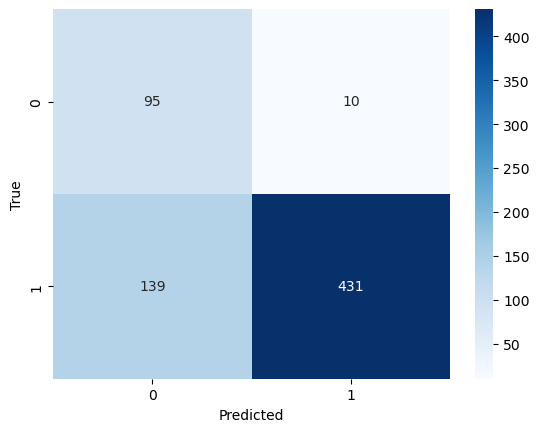

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = (model.predict(x_test) > 0.5).astype(int)
cm = confusion_matrix(y_test.astype(int), y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()